# ResNet50 on MURA

Directly using ResNet50 from Keras: https://keras.io/applications/#resnet50

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.resnet50 import ResNet50
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 736 ms


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 3.65 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 2.06 s


We can look at the shape of the dataset:

In [5]:
x_train.shape

(36808, 256, 256)

time: 3.68 ms


In [6]:
size = x_train.shape[1]

time: 4.56 ms


Visually inspect an image:

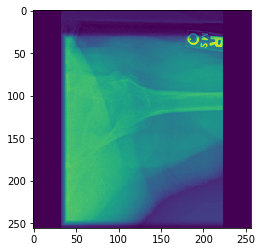

time: 123 ms


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Data preparation

reshape the data to `size*size*1`  (1 for channel)

In [8]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.16 ms


In [9]:
x_train.shape

(36808, 256, 256, 1)

time: 2.1 ms


Convert our data type to float32 and normalize our data values to the range [0, 1].

In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.03 s


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 1.73 ms


In [12]:
y_train.shape

(36808, 2)

time: 14.5 ms


In [13]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 3.35 ms


In [14]:
datagen.fit(x_train)

time: 4.15 s


## Define model architecture

In [15]:
# declare sequential model
with tf.device('/GPU:1'):
    model = ResNet50(input_shape=(256, 256, 1), weights=None, classes=2)

time: 4.3 s


In [16]:
model.output_shape

(None, 2)

time: 2.02 ms


In [17]:
adam = optimizers.Adam(amsgrad=False) #try true later

time: 14.3 ms


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

time: 22.5 ms


## Fitting the model

### First 50 epoches

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=10, verbose=2)

In [20]:
model.save('./trained_models/1_1_resnet50_mura3.h5')

time: 10.8 s


We can check how loss and accuracy change over epochs

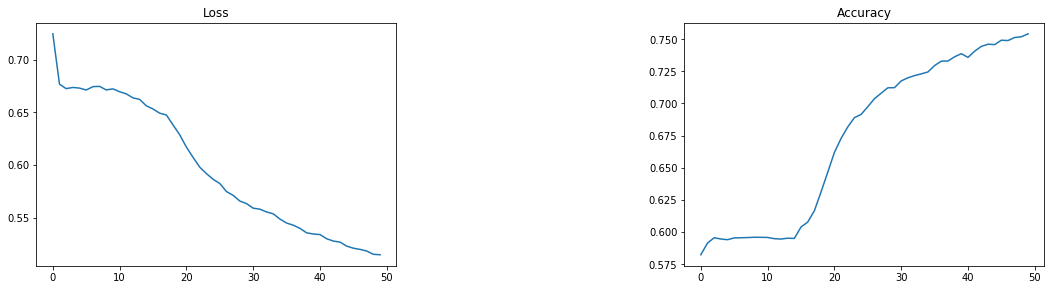

time: 205 ms


In [21]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [22]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_1_resnet50_mura3.h5')

time: 20.2 s


## Evaluating our model on the test set

### Loss and Accuracy

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 15.4 s


In [24]:
score

[0.705406739212477, 0.6562402254162186]

time: 5.41 ms


In [25]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 14.8 s


In [26]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.39 ms


### Cohen's Kappa

In [27]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 3.12 ms


In [28]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.05 ms


In [29]:
kappa

0.2919911746326912

time: 2.2 ms


[[1623   44]
 [1055  475]]


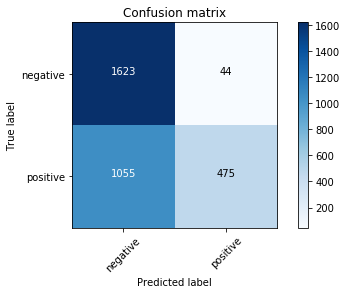

time: 178 ms


In [30]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

### epoches 50-100

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=10, verbose=2)

In [32]:
model.save('./trained_models/1_1_resnet50_mura3_100.h5')

time: 23.8 s


We can check how loss and accuracy change over epochs

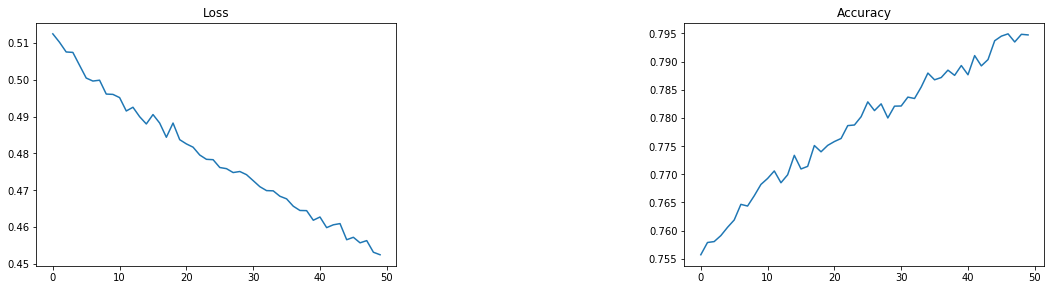

time: 233 ms


In [33]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [34]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_1_resnet50_mura3_100.h5')

time: 25.1 s


## Evaluating our model on the test set

### Loss and Accuracy

In [35]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 16.3 s


In [36]:
score

[0.7321902448809591, 0.6681263683026457]

time: 4.01 ms


In [37]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 16 s


In [38]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 1.69 ms


### Cohen's Kappa

In [39]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 4.18 ms


In [40]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.32 ms


In [41]:
kappa

0.3177902790831164

time: 2.85 ms


[[1607   60]
 [1001  529]]


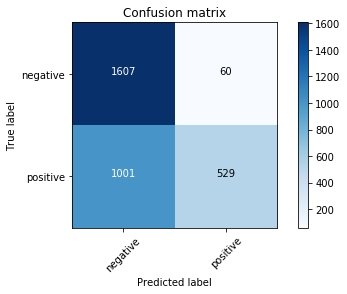

time: 187 ms


In [42]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

### epoches 100-110

In [43]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=10, verbose=2)

Epoch 1/10
 - 557s - loss: 0.4519 - acc: 0.7956
Epoch 2/10
 - 554s - loss: 0.4497 - acc: 0.7970
Epoch 3/10
 - 549s - loss: 0.4510 - acc: 0.7963
Epoch 4/10
 - 550s - loss: 0.4493 - acc: 0.7964
Epoch 5/10
 - 568s - loss: 0.4508 - acc: 0.7956
Epoch 6/10
 - 551s - loss: 0.4465 - acc: 0.7992
Epoch 7/10
 - 557s - loss: 0.4476 - acc: 0.7980
Epoch 8/10
 - 575s - loss: 0.4467 - acc: 0.7993
Epoch 9/10
 - 550s - loss: 0.4442 - acc: 0.7973
Epoch 10/10
 - 555s - loss: 0.4424 - acc: 0.8021


time: 1h 32min 45s


In [55]:
model.save('./trained_models/1_1_resnet50_mura3_110.h5')

time: 40.3 s


We can check how loss and accuracy change over epochs

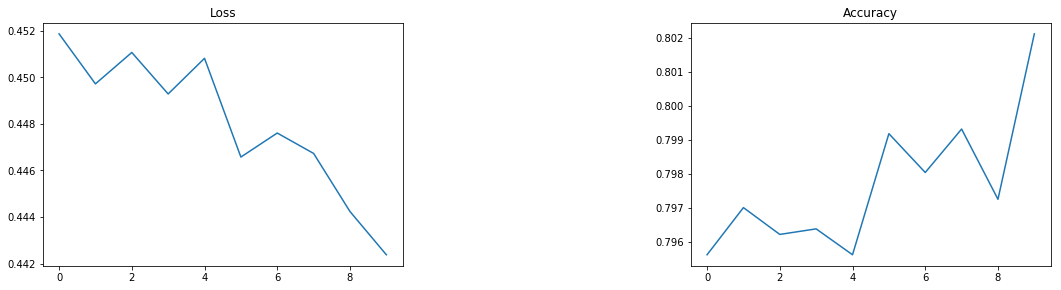

time: 254 ms


In [45]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [46]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_1_resnet50_mura3_110.h5')

time: 28.7 s


## Evaluating our model on the test set

### Loss and Accuracy

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 16.3 s


In [48]:
score

[0.6303743988527221, 0.6997184861552764]

time: 2.76 ms


In [49]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 16.4 s


In [50]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.47 ms


### Cohen's Kappa

In [51]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 5.89 ms


In [52]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.32 ms


In [53]:
kappa

0.4025680975662171

time: 3.71 ms


[[1055  612]
 [ 348 1182]]


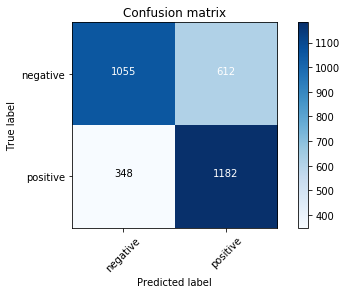

time: 190 ms


In [54]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

### epoches 110-150

In [43]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=40, verbose=2)

Epoch 1/10
 - 557s - loss: 0.4519 - acc: 0.7956
Epoch 2/10
 - 554s - loss: 0.4497 - acc: 0.7970
Epoch 3/10
 - 549s - loss: 0.4510 - acc: 0.7963
Epoch 4/10
 - 550s - loss: 0.4493 - acc: 0.7964
Epoch 5/10
 - 568s - loss: 0.4508 - acc: 0.7956
Epoch 6/10
 - 551s - loss: 0.4465 - acc: 0.7992
Epoch 7/10
 - 557s - loss: 0.4476 - acc: 0.7980
Epoch 8/10
 - 575s - loss: 0.4467 - acc: 0.7993
Epoch 9/10
 - 550s - loss: 0.4442 - acc: 0.7973
Epoch 10/10
 - 555s - loss: 0.4424 - acc: 0.8021


time: 1h 32min 45s


In [ ]:
model.save('./trained_models/1_1_resnet50_mura3_150.h5')

We can check how loss and accuracy change over epochs

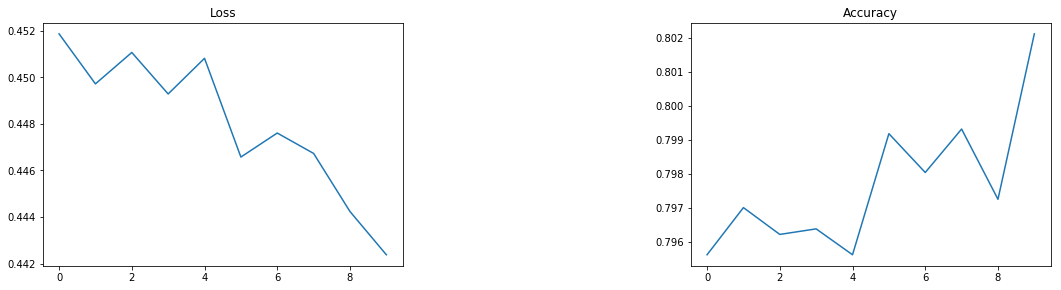

time: 254 ms


In [45]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [46]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_1_resnet50_mura3_150.h5')

time: 28.7 s


## Evaluating our model on the test set

### Loss and Accuracy

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 16.3 s


In [48]:
score

[0.6303743988527221, 0.6997184861552764]

time: 2.76 ms


In [49]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 16.4 s


In [50]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.47 ms


### Cohen's Kappa

In [51]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 5.89 ms


In [52]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.32 ms


In [53]:
kappa

0.4025680975662171

time: 3.71 ms


[[1055  612]
 [ 348 1182]]


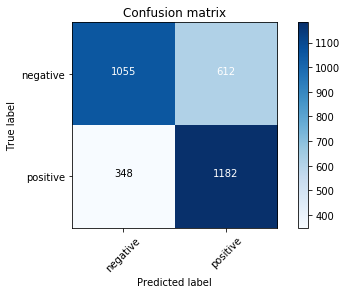

time: 190 ms


In [54]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))